<a href="https://colab.research.google.com/github/Charliebond125/ANERGY_Project/blob/main/CE802_P2_Notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Loading, preprocessing and feature engineering pipeline

import numpy as np
import pandas as pd
import seaborn as sns
import math
import os

from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

from collections import defaultdict

from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from scipy.spatial.distance import squareform

from sklearn.inspection import permutation_importance
from sklearn.model_selection import train_test_split

from sklearn.preprocessing import OneHotEncoder

In [2]:
import matplotlib.pyplot as plt

In [71]:
""" Providing it as a GitHub link to a repo where the data has been saved """

df = pd.read_csv(r'https://raw.githubusercontent.com/Charliebond125/ANERGY_Project/main/CE802_P2_Data.csv')

In [70]:
df.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F13,F14,F15,F16,F17,F18,F19,F20,F21,Class
0,-1.23,3.5390,-9.3000,1790.680,-5.6516,3501.98,2.9934,-0.5706,0,-1814.35,...,160.8874,6.4308,-44596.830,-8.4228,-129.147,2947.14,12.1050,-2.47360,NaN,False
1,-1.23,3.6255,-8.5150,2078.580,-12.1280,2880.88,5.3400,-1.1787,1,-3528.65,...,162.0042,8.9960,-44648.430,-9.1352,942.750,1812.46,9.7653,-1.88392,-13.05,False
2,-4.23,3.7488,-5.1830,1661.386,-6.6568,3224.18,3.1860,-4.1640,0,-2019.95,...,161.6324,6.2560,-44388.540,-10.6760,-445.770,1568.94,9.6048,-3.57060,NaN,False
3,-4.23,4.5770,-13.5076,1721.000,-6.1650,3818.78,4.3329,-6.3180,1,-2637.55,...,167.0780,6.4616,-44291.700,-9.0568,707.550,2693.14,11.6637,-2.44000,NaN,True
4,-1.23,3.6344,-9.2120,1807.380,-6.0992,2797.64,2.6697,-1.2141,0,-1953.15,...,167.5520,13.9400,-44189.862,-8.0792,-1712.850,2056.94,10.4574,-2.42340,-14.82,False


In [72]:
df_cols = df.columns.tolist()

In [73]:
imputer = IterativeImputer()

imputed_df = imputer.fit_transform(df); imputed_df = pd.DataFrame(imputed_df, columns=df.columns)

df_copy = imputed_df

In [74]:
df_copy.shape

(1000, 22)

In [75]:
# creating minmax scaling algorithm

def my_normalized_data(data):
    return (data - np.min(data)) / (np.max(data) - np.min(data))

In [76]:
df_copy = my_normalized_data(df_copy)

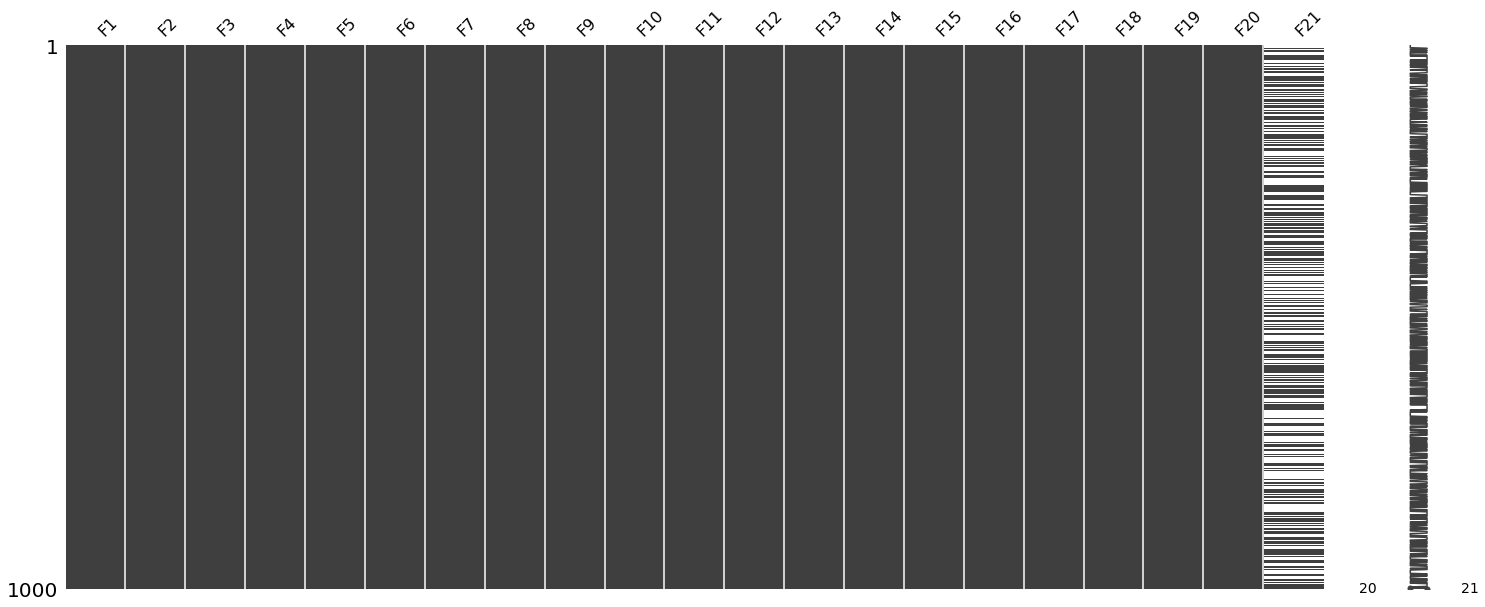

In [ ]:
import missingno as msno

msno.matrix(df.drop('Class', axis='columns').sample(1000))
plt.savefig('/content/drive/MyDrive/Graphs/Missing_value_matrix.png')

plt.show()

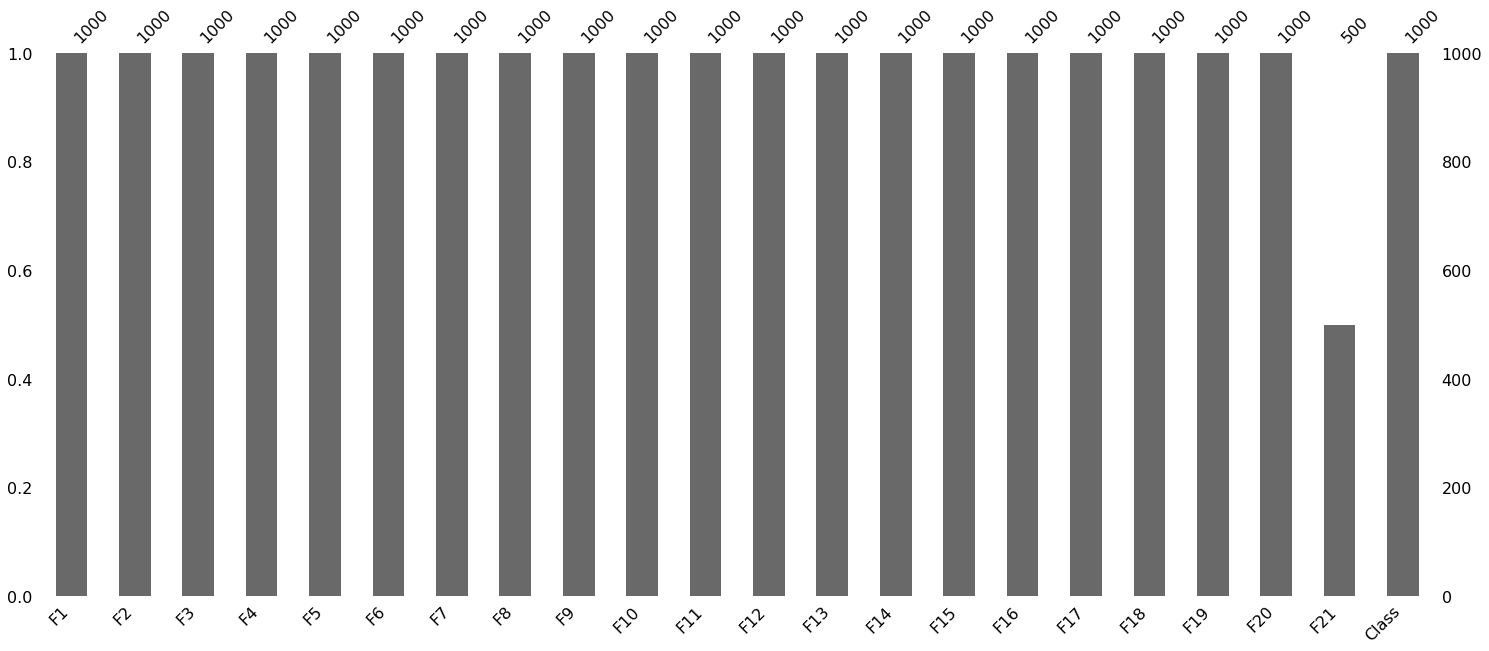

In [ ]:
msno.bar(df)
plt.savefig('/content/drive/MyDrive/Graphs/Missing_value_bar.png')
plt.show()

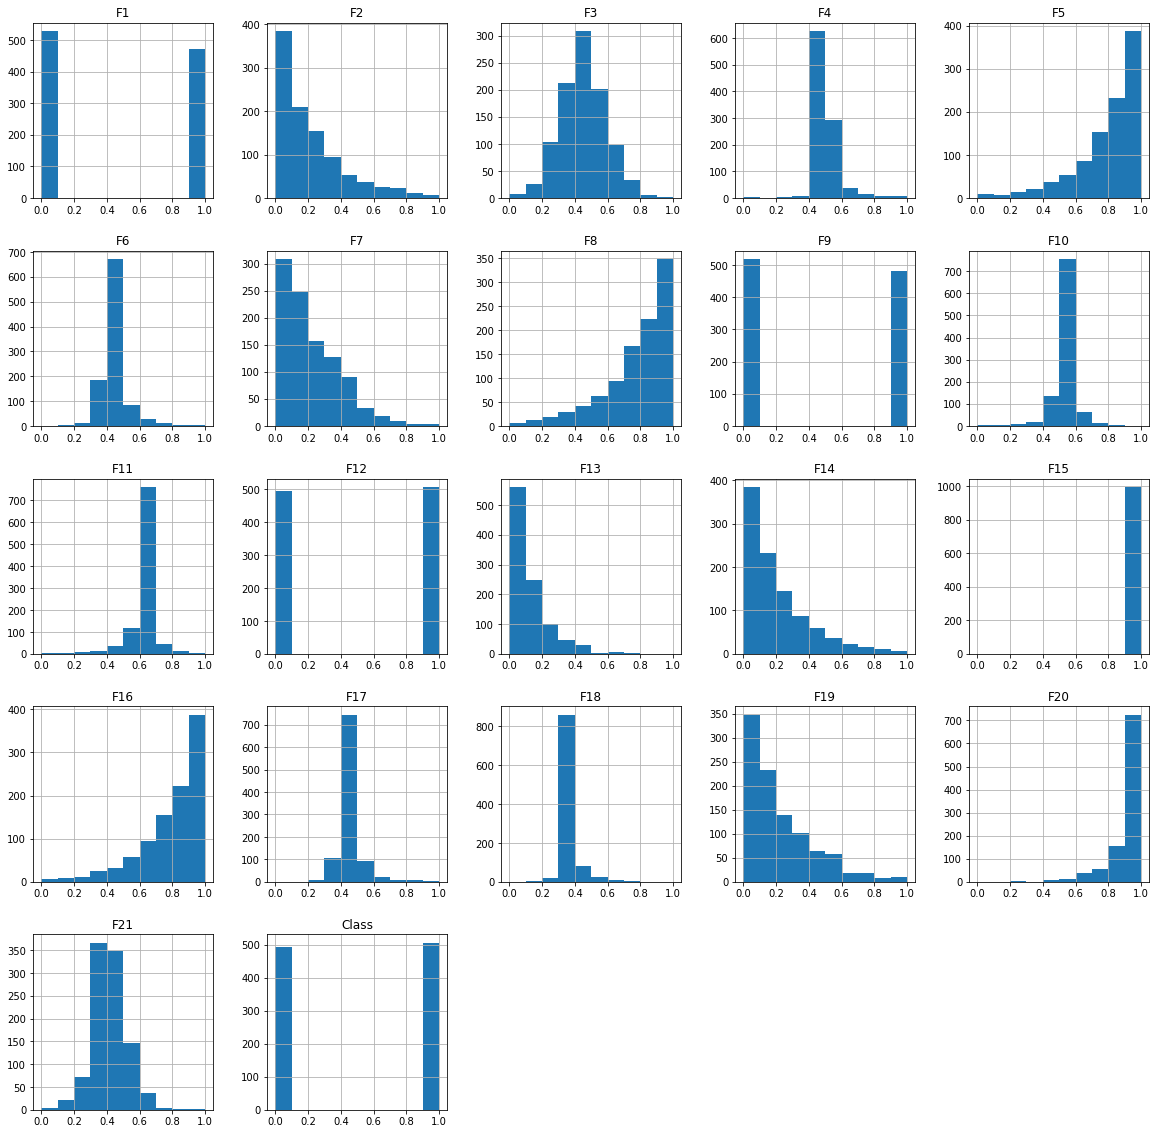

In [ ]:
p_hist = imputed_df.hist(figsize=(20,20))
plt.savefig('/content/drive/MyDrive/Graphs/histogram.png')

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


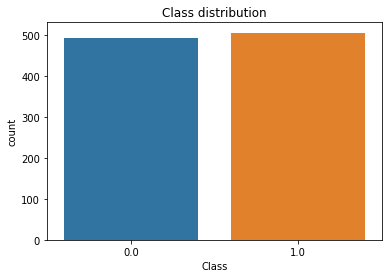

In [ ]:
# Looking at target variable 

sns.countplot(imputed_df['Class'])
plt.title('Class distribution')
plt.savefig('/content/drive/MyDrive/Graphs/Bar_chart_class_dist.png')

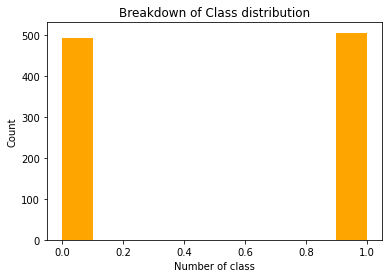

In [ ]:
class_count = imputed_df["Class"]

plt.hist(class_count, color='orange')
plt.title('Breakdown of Class distribution')
plt.xlabel('Number of class')
plt.ylabel('Count')
plt.savefig('/content/drive/MyDrive/Graphs/Breakdown_class.png')

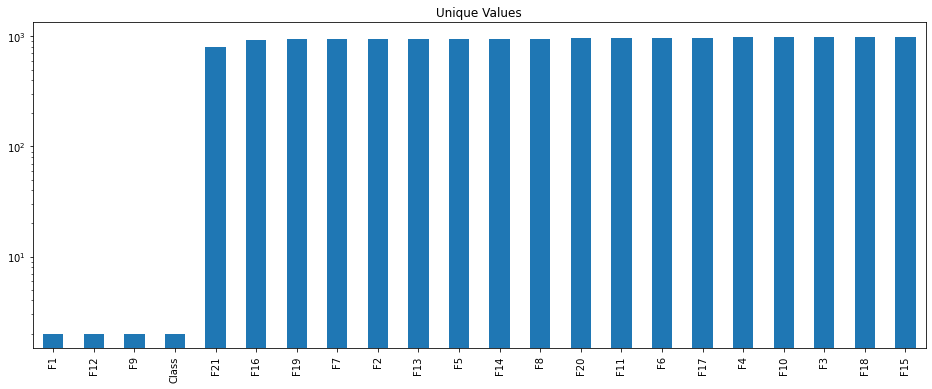

In [ ]:
unique_selection = imputed_df.select_dtypes(include="number").nunique().sort_values()

unique_selection.plot.bar(logy=True, figsize=(16, 6), title = "Unique Values")
plt.savefig('/content/drive/MyDrive/Graphs/Unique_values_barchart.png')
plt.show()

<ipython-input-30-3959a1ee01ce>:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))


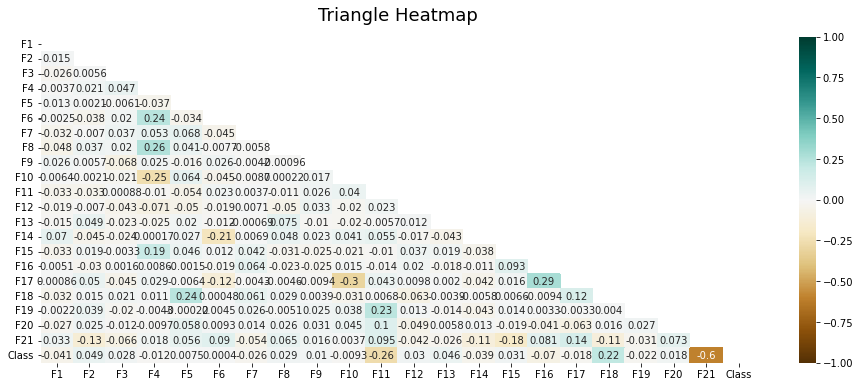

In [ ]:
plt.figure(figsize=(16, 6))

mask = np.triu(np.ones_like(df.corr(), dtype=np.bool))

heatmap = sns.heatmap(imputed_df.corr(), mask=mask, vmin=-1, vmax=1, annot=True, cmap='BrBG')

heatmap.set_title('Triangle Heatmap', fontdict={'fontsize':18}, pad=16);
plt.savefig('/content/drive/MyDrive/Graphs/EDA_Heatmap.png')
plt.show()

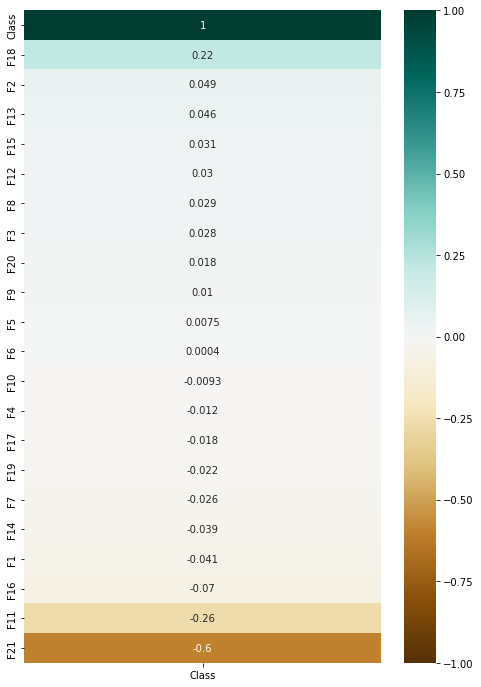

In [ ]:
plt.figure(figsize=(8, 12))

heatmap = sns.heatmap(imputed_df.corr()[['Class']].sort_values(by='Class', ascending=False), vmin=-1, vmax=1, annot=True, cmap='BrBG')
plt.savefig('/content/drive/MyDrive/Graphs/Classes_corr.png')
plt.show()

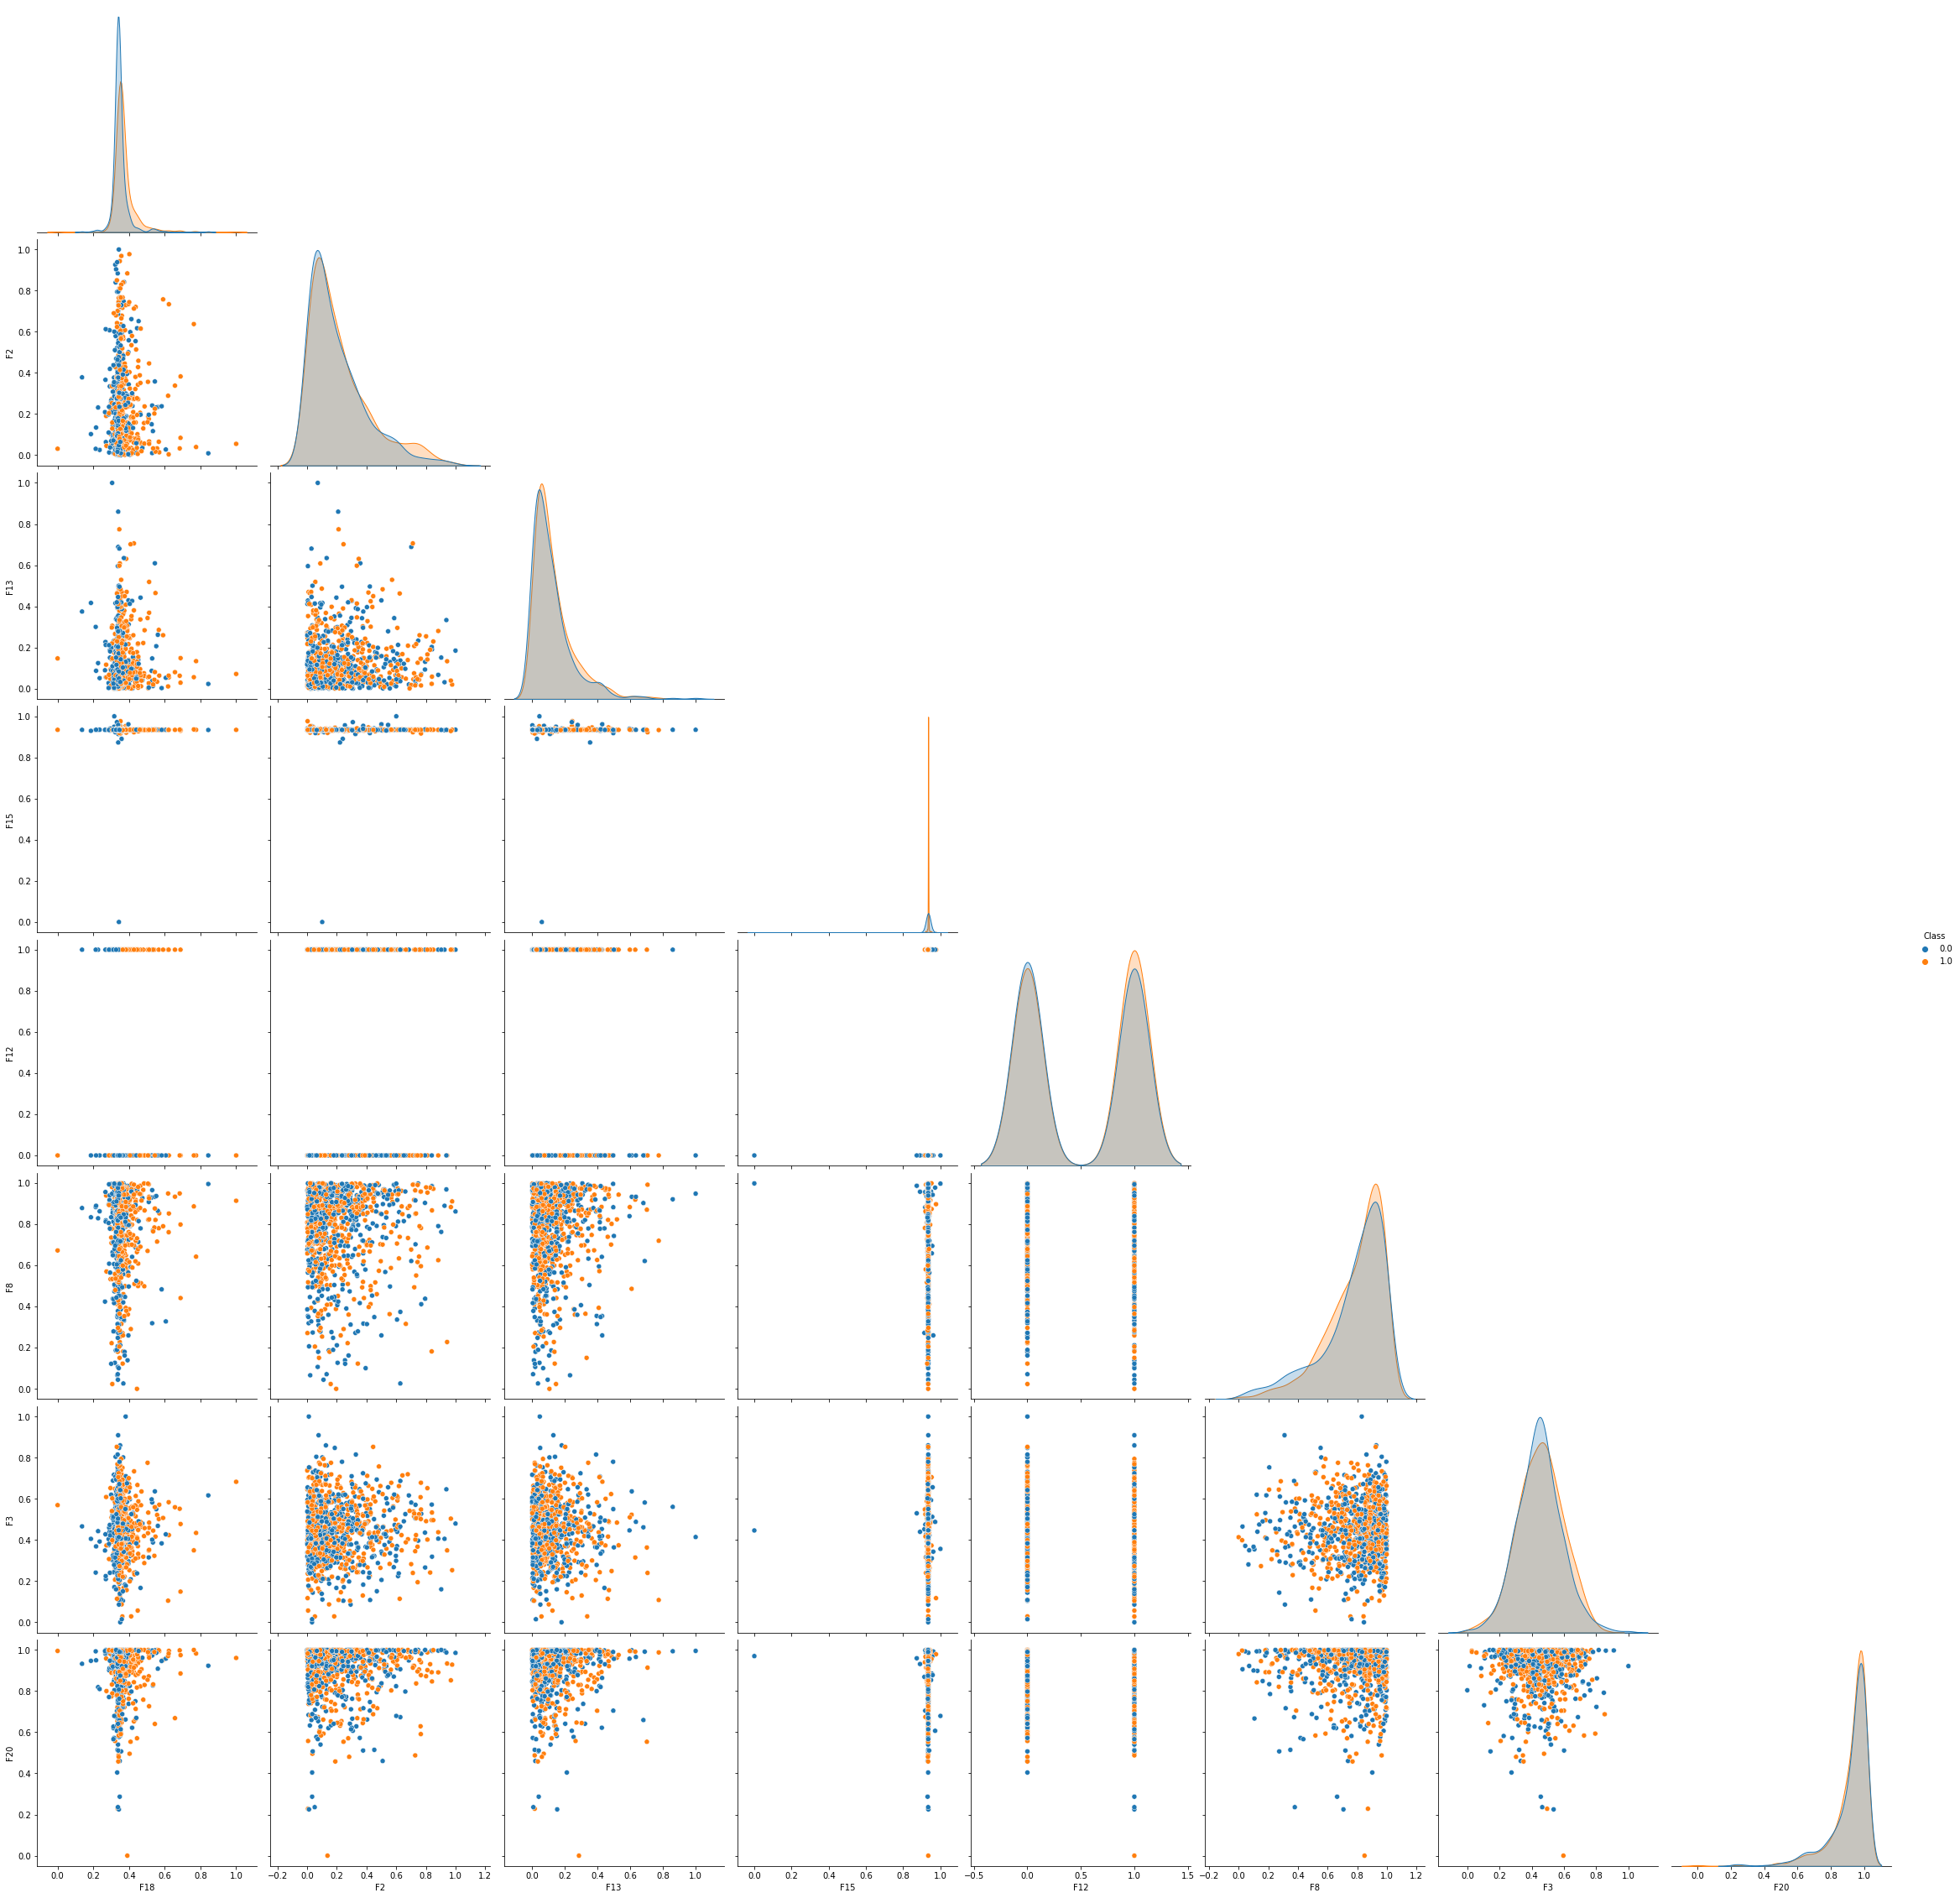

In [ ]:
# Taking the first n features above 0.25 as most statistically significant

""" At a later stage I feel PCA will be very useful in identifying latent features in our data """

df_scatter = ['Class', 'F18', 'F2', 'F13', 'F15', 'F12', 'F8', 'F3', 'F20']

sns.pairplot(imputed_df[df_scatter], height=4, kind='scatter', hue='Class', corner=True, )
plt.savefig('/content/drive/MyDrive/Graphs/df_scatter.png')
plt.show()

#diag_kind="hist"

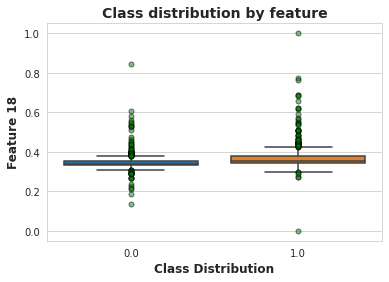

In [ ]:
""" outlier analysis """

# box plots for each feature in granular analysis

flierprops = dict(marker='o', markersize=5, markeredgecolor='black', markerfacecolor='green', alpha=0.5)

a = sns.set_style('whitegrid')
a = sns.boxplot(x=df['Class'], y=df['F18'], flierprops=flierprops)
a.set_ylabel("Feature 18", fontsize= 12, fontweight="bold")
a.set_xlabel("Class Distribution", fontsize=12, fontweight="bold")
a.set_title("Class distribution by feature", fontsize=14, fontweight="bold")
plt.savefig('F18_boxplot.png')
plt.show()




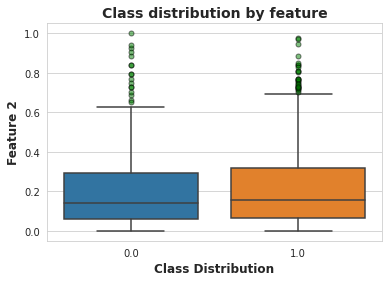

In [ ]:
b = sns.set_style('whitegrid')
b = sns.boxplot(x=df['Class'], y=df['F2'], flierprops=flierprops)
b.set_ylabel("Feature 2", fontsize= 12, fontweight="bold")
b.set_xlabel("Class Distribution", fontsize=12, fontweight="bold")
b.set_title("Class distribution by feature", fontsize=14, fontweight="bold")
plt.savefig('/content/drive/MyDrive/Graphs/F2_boxplot.png')
plt.show()

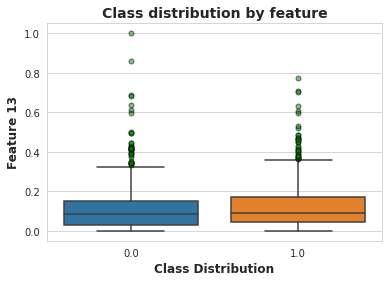

In [ ]:
c = sns.set_style('whitegrid')
c = sns.boxplot(x=df['Class'], y=df['F13'], flierprops=flierprops)
c.set_ylabel("Feature 13", fontsize= 12, fontweight="bold")
c.set_xlabel("Class Distribution", fontsize=12, fontweight="bold")
c.set_title("Class distribution by feature", fontsize=14, fontweight="bold")
plt.savefig('/content/drive/MyDrive/Graphs/F13_boxplot.png')
plt.show()

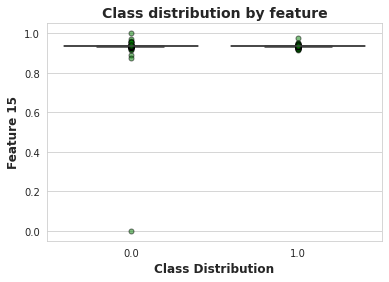

In [ ]:
d = sns.set_style('whitegrid')
d = sns.boxplot(y=df['F15'], x=df['Class'], flierprops=flierprops)
d.set_ylabel("Feature 15", fontsize= 12, fontweight="bold")
d.set_xlabel("Class Distribution", fontsize=12, fontweight="bold")
d.set_title("Class distribution by feature", fontsize=14, fontweight="bold")
plt.savefig('/content/drive/MyDrive/Graphs/F15_boxplot.png')
plt.show()

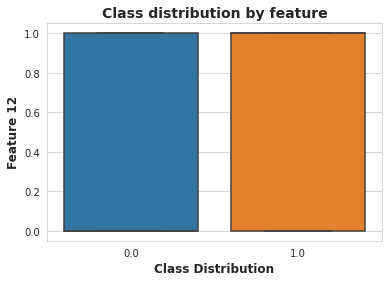

In [ ]:
e = sns.set_style('whitegrid')
e = sns.boxplot(y=df['Class'], x=df['F12'], flierprops=flierprops)
e.set_ylabel("Feature 12", fontsize= 12, fontweight="bold")
e.set_xlabel("Class Distribution", fontsize=12, fontweight="bold")
e.set_title("Class distribution by feature", fontsize=14, fontweight="bold")
plt.savefig('/content/drive/MyDrive/Graphs/F12_boxplot.png')
plt.show()

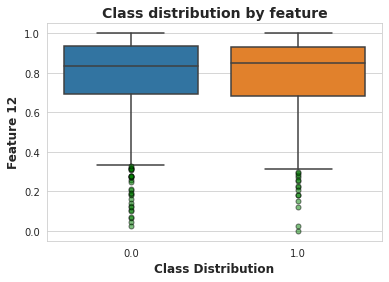

In [ ]:
f = sns.set_style('whitegrid')
f = sns.boxplot(x=df['Class'], y=df['F8'], flierprops=flierprops)
f.set_ylabel("Feature 12", fontsize= 12, fontweight="bold")
f.set_xlabel("Class Distribution", fontsize=12, fontweight="bold")
f.set_title("Class distribution by feature", fontsize=14, fontweight="bold")
plt.savefig('/content/drive/MyDrive/Graphs/F8_boxplot.png')
plt.show()

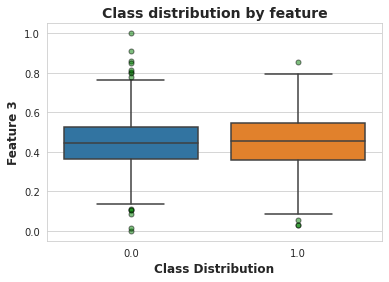

In [ ]:
g = sns.set_style('whitegrid')
g = sns.boxplot(x=df['Class'], y=df['F3'], flierprops=flierprops)
g.set_ylabel("Feature 3", fontsize= 12, fontweight="bold")
g.set_xlabel("Class Distribution", fontsize=12, fontweight="bold")
g.set_title("Class distribution by feature", fontsize=14, fontweight="bold")
plt.savefig('/content/drive/MyDrive/Graphs/F3_boxplot.png')
plt.show()

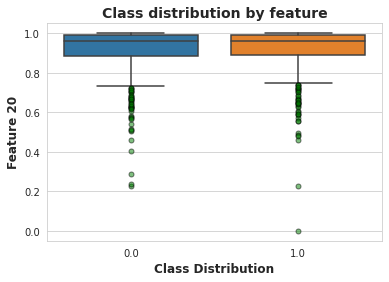

In [ ]:
h = sns.set_style('whitegrid')
h = sns.boxplot(x=df['Class'], y=df['F20'], flierprops=flierprops)
h.set_ylabel("Feature 20", fontsize= 12, fontweight="bold")
h.set_xlabel("Class Distribution", fontsize=12, fontweight="bold")
h.set_title("Class distribution by feature", fontsize=14, fontweight="bold")
plt.savefig('/content/drive/MyDrive/Graphs/F20_boxplot.png')
plt.show()

In [ ]:
fig = px.box(df)
plt.savefig('/content/drive/MyDrive/Graphs/General_boxplot.png')
fig.show()

<Figure size 432x288 with 0 Axes>

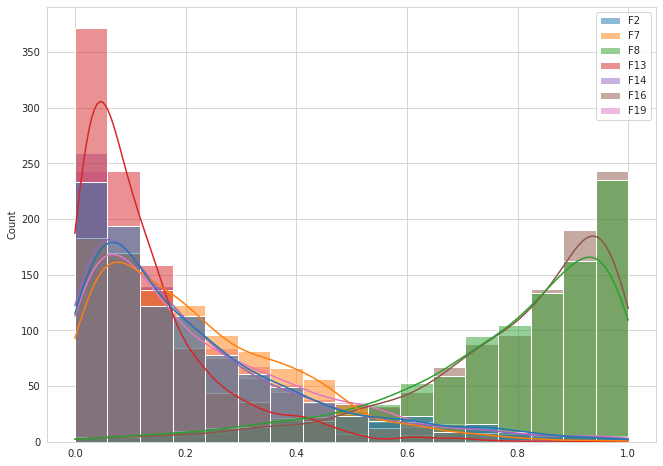

In [ ]:
df_skewed = ['F2', 'F7', 'F8', 'F13', 'F14', 'F16', 'F19']

plt.figure(figsize=(24,8))
plt.subplot(1,2,1)
sns.histplot(df[df_skewed], kde=True)

plt.savefig('/content/drive/MyDrive/Graphs/skewed_histplot.png')
plt.show()

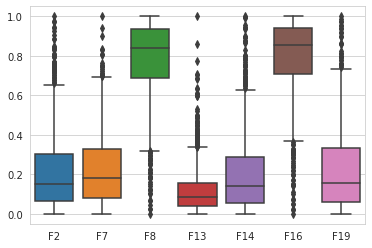

In [ ]:
sns.boxplot(data = df[df_skewed])
plt.savefig('/content/drive/MyDrive/Graphs/skewed_feature_boxplot.png')

In [77]:
encoder = OneHotEncoder(sparse=False)

encoder.fit_transform(df_copy)


array([[0., 1., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 1., 0.],
       [1., 0., 0., ..., 0., 1., 0.],
       ...,
       [1., 0., 0., ..., 0., 1., 0.],
       [0., 1., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 1., 0.]])

In [78]:
df_copy

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F13,F14,F15,F16,F17,F18,F19,F20,F21,Class
0,1.0,0.021560,0.597764,0.520025,0.967538,0.503944,0.064176,0.980365,0.0,0.624838,...,0.002096,0.037876,0.931620,0.918192,0.414685,0.404247,0.221246,0.936954,0.524858,0.0
1,1.0,0.040826,0.620269,0.609130,0.240132,0.431258,0.285111,0.935179,1.0,0.393301,...,0.008924,0.319641,0.931315,0.839261,0.454283,0.339125,0.044021,0.987632,0.646952,0.0
2,0.0,0.068288,0.715797,0.480008,0.854638,0.471434,0.082309,0.713349,0.0,0.597069,...,0.006651,0.018675,0.932849,0.668546,0.402988,0.325149,0.031864,0.842678,0.485975,0.0
3,0.0,0.252751,0.477133,0.498459,0.909875,0.541018,0.190291,0.553292,1.0,0.513655,...,0.039946,0.041259,0.933420,0.847947,0.445595,0.389669,0.187819,0.939842,0.378702,1.0
4,1.0,0.042808,0.600287,0.525193,0.917266,0.421517,0.033699,0.932548,0.0,0.606091,...,0.042844,0.862698,0.934021,0.956262,0.356179,0.353157,0.096446,0.941269,0.430894,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,0.0,0.167825,0.446884,0.432962,0.779251,0.401961,0.121937,0.939325,0.0,0.558131,...,0.170801,0.203890,0.934594,0.937936,0.383952,0.342145,0.397358,0.995497,0.474866,0.0
996,1.0,0.533164,0.602351,0.495667,0.660645,0.467607,0.482828,0.832657,0.0,0.535496,...,0.142186,0.106702,0.930586,0.915467,0.426366,0.353650,0.083152,0.990033,0.474838,0.0
997,0.0,0.903782,0.160264,0.511937,0.882695,0.476887,0.731387,0.762838,1.0,0.525377,...,0.150868,0.055648,0.933807,0.939310,0.445772,0.327479,0.341229,0.999972,0.648172,0.0
998,1.0,0.167090,0.221273,0.492244,0.989361,0.418066,0.378603,0.599436,1.0,0.528125,...,0.174836,0.749781,0.932907,0.827428,0.426011,0.364922,0.229881,0.908388,0.323155,1.0


In [89]:
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import RobustScaler
from sklearn.pipeline import Pipeline

X = df_copy.drop(['Class'], axis=1)
y = df_copy['Class']

In [80]:
""" 
Winsorizing and trimming Extreme Outliers using 

"""



' \nWinsorizing and trimming Extreme Outliers using \n\n'

In [90]:
X = X.drop_duplicates()

In [91]:
X.shape

(1000, 21)

In [92]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   F1      1000 non-null   float64
 1   F2      1000 non-null   float64
 2   F3      1000 non-null   float64
 3   F4      1000 non-null   float64
 4   F5      1000 non-null   float64
 5   F6      1000 non-null   float64
 6   F7      1000 non-null   float64
 7   F8      1000 non-null   float64
 8   F9      1000 non-null   float64
 9   F10     1000 non-null   float64
 10  F11     1000 non-null   float64
 11  F12     1000 non-null   float64
 12  F13     1000 non-null   float64
 13  F14     1000 non-null   float64
 14  F15     1000 non-null   float64
 15  F16     1000 non-null   float64
 16  F17     1000 non-null   float64
 17  F18     1000 non-null   float64
 18  F19     1000 non-null   float64
 19  F20     1000 non-null   float64
 20  F21     1000 non-null   float64
dtypes: float64(21)
memory usage: 171.9 KB


In [93]:
X.describe().T

,count,mean,std,min,25%,50%,75%,max
F1,1000.0,0.471000,0.499408,0.0,0.000000,0.000000,1.000000,1.0
F2,1000.0,0.212854,0.201070,0.0,0.063316,0.149561,0.301138,1.0
F3,1000.0,0.450352,0.139382,0.0,0.362392,0.449253,0.538511,1.0
F4,1000.0,0.507851,0.076304,0.0,0.480953,0.491188,0.512020,1.0
F5,1000.0,0.798117,0.191714,0.0,0.716129,0.859052,0.939864,1.0
F6,1000.0,0.436517,0.082258,0.0,0.403619,0.420327,0.447440,1.0
F7,1000.0,0.218620,0.173477,0.0,0.081095,0.180815,0.325925,1.0
F8,1000.0,0.779566,0.201248,0.0,0.687602,0.841697,0.934165,1.0
F9,1000.0,0.481000,0.499889,0.0,0.000000,0.000000,1.000000,1.0
F10,1000.0,0.530005,0.069095,0.0,0.511899,0.531485,0.548312,1.0


In [94]:
X.kurtosis()

#  With high or low kurtosis, if it is positive this is leptokurtic distribuition, if it is negative it is Platykurtic.
# if near zero, it is mesokurtic. 

"""

Normal Distributions have a kurtosis of 3. Excess can be calculated by subracting kurtosis - 3.
Heavy tailed, or short tailed is what we are looking to mitigate to improve predictive performance.

"""


'\n\nNormal Distributions have a kurtosis of 3. Excess can be calculated by subracting kurtosis - 3.\nHeavy tailed, or short tailed is what we are looking to mitigate to improve predictive performance.\n\n'

In [95]:
X.skew()

F1      0.116370
F2      1.409531
F3      0.038875
F4      2.293913
F5     -1.534271
F6      2.262716
F7      1.066796
F8     -1.327683
F9      0.076169
F10    -0.810363
F11    -2.418307
F12    -0.028045
F13     2.149838
F14     1.496661
F15   -30.538670
F16    -1.483233
F17     2.474472
F18     3.536176
F19     1.309206
F20    -2.643845
F21     0.115479
dtype: float64

In [96]:
X = X.values
y = y.values

In [97]:
X.shape

(1000, 21)

In [98]:
y.shape

(1000,)

In [99]:
# take a baseline test against all features

X_train, X_test, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state=42, shuffle=True)

"""
stratify == yes, shuffle = True
Same size classes distribution across n samples
y_val == validation set

"""

'\nstratify == yes, shuffle = True\nSame size classes distribution across n samples\ny_val == validation set\n\n'

In [101]:
y_val

array([0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 0., 1., 1., 0., 0.,
       1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0.,
       1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0.,
       1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 1., 1., 0.,
       0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0.,
       1., 1., 1., 0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 0.,
       1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 0., 1.,
       1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 0.,
       0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1.,
       1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0.,
       0., 1., 1., 1., 0.

In [102]:
"""
Using an isolation forest to detect outliers in the data, and return new array without outliers.

With this, we can see we have removed n number of outliers using Isolation Forest

Even though Tree based algorithms are robust against outliers and skew/kurtosis,
it is good practice to mitigate against if we want to use other algorithms.

"""


from sklearn.ensemble import IsolationForest
from sklearn.metrics import mean_absolute_error

# identfying outliers in dataset

iso = IsolationForest(contamination=0.1)
yhat = iso.fit_predict(X_train)

# Selecting rows that are not outliers, and then removing using the mask

mask = yhat != -1
X_train, y_train = X_train[mask, :], y_train[mask]
#X_test, y_val = X_test[mask, :], y_val[mask]

In [103]:
print(X_train.shape, y_train.shape, X_test.shape, y_val.shape)

(630, 21) (630,) (300, 21) (300,)


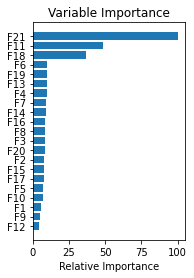

In [104]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel


"""
Deciding Feature importance between features
X features, y target

"""

clf = RandomForestClassifier()
clf = clf.fit(X_train, y_train)
feature_importance = clf.feature_importances_

feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5

plt.subplot(1, 2, 2)
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, df.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Variable Importance')
plt.show()


In [105]:
import time
import numpy as np

feature_names = [f"feature {i}" for i in range(X.shape[1])]
forest = RandomForestClassifier(random_state=42, n_estimators=50)
forest.fit(X_train, y_train)

start_time = time.time()
importances = forest.feature_importances_
std = np.std([tree.feature_importances_ for tree in forest.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 0.005 seconds


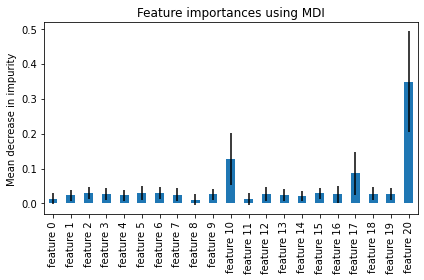

In [106]:
forest_importances = pd.Series(importances, index=feature_names)

fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=std, ax=ax)
ax.set_title("Feature importances using MDI")
ax.set_ylabel("Mean decrease in impurity")
fig.tight_layout()

In [107]:
from sklearn.inspection import permutation_importance

start_time = time.time()
result = permutation_importance(
    forest, X_test, y_val, n_repeats=10, random_state=42, n_jobs=10
)
elapsed_time = time.time() - start_time
print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

forest_importances = pd.Series(result.importances_mean, index=feature_names)

Elapsed time to compute the importances: 8.378 seconds


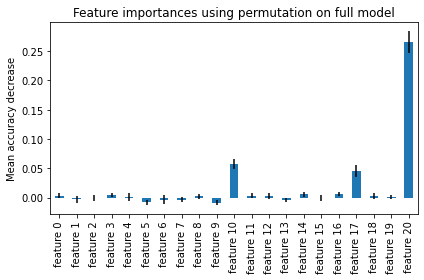

In [108]:
fig, ax = plt.subplots()
forest_importances.plot.bar(yerr=result.importances_std, ax=ax)
ax.set_title("Feature importances using permutation on full model")
ax.set_ylabel("Mean accuracy decrease")
fig.tight_layout()
plt.show()

In [109]:
"""

Creating a new pipeline to iterate over the three classifiers as outlined in the report

This will mean using a cross validation method to define the best parameters for the models.
Once completed, hyperparameter tuning can begin to further refine the model. The model can be saved and then
implemented going forward.

  - Decision Tree Classifier (Implementing to give a baseline)
  - RandomForestClassifier
  - SupportVectorClassifier

  # using a quantile transformer which already contains a normalization/standardization step
  # Setting it to Gaussian Normal Distribution as seen from EDA, data is highly skewed.

"""

from sklearn.svm import SVC
from sklearn.model_selection import cross_validate

# creating an empty list to store the classifiers

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

from sklearn.metrics import accuracy_score

from sklearn.preprocessing import QuantileTransformer


qt = QuantileTransformer(n_quantiles=100, output_distribution='normal')


pipeline = Pipeline([
    ('Transformer', qt),
    
    ('clf', RandomForestClassifier()) #step2 - classifier
])


pipeline.steps

clfs = []
clfs.append(SVC())
clfs.append(DecisionTreeClassifier())
clfs.append(RandomForestClassifier())


for classifier in clfs:
    pipeline.set_params(clf = classifier)
    scores = cross_validate(pipeline, X_train, y_train)
    print('---------------------------------')
    print(str(classifier))
    print('-----------------------------------')
    for key, values in scores.items():
            print(key,' mean ', values.mean())
            print(key,' std ', values.std())


---------------------------------
SVC()
-----------------------------------
fit_time  mean  0.033201742172241214
fit_time  std  0.003472880255012475
score_time  mean  0.014829540252685547
score_time  std  0.00032249567636521916
test_score  mean  0.8603174603174603
test_score  std  0.018510958396334272
---------------------------------
DecisionTreeClassifier()
-----------------------------------
fit_time  mean  0.027808427810668945
fit_time  std  0.001598270900104124
score_time  mean  0.01345057487487793
score_time  std  0.0034017616552123923
test_score  mean  0.7936507936507937
test_score  std  0.02969569354582494
---------------------------------
RandomForestClassifier()
-----------------------------------
fit_time  mean  0.2573733329772949
fit_time  std  0.015963547862452847
score_time  mean  0.023359203338623048
score_time  std  0.0009273768620591848
test_score  mean  0.8857142857142856
test_score  std  0.034265131976068106


In [110]:
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn import metrics

from sklearn.metrics import accuracy_score

from sklearn.preprocessing import QuantileTransformer

#cross val set up
cross_val = RepeatedStratifiedKFold(n_splits=10, n_repeats =10, random_state=42)

# transformers
qt = QuantileTransformer(n_quantiles=100, output_distribution='normal')
pt = PowerTransformer(method='yeo-johnson', standardize=True, copy=False)

# scalers
scaler = RobustScaler(with_centering=True, with_scaling=True, unit_variance=True)

# classifiers
clf = DecisionTreeClassifier(random_state=42)

# pipeline
pipe = Pipeline([('Transformer', qt),
                 ('Classifier', clf)])
pipe.steps

# Parameter
parameters = {'max_depth':range(3,100),
              'max_features': ['sqrt', 'log2'],
              'min_samples_leaf':[2,5,10,15,20],
              'min_samples_split':[2,8,10,12,18,20,16],
              'criterion':['gini','entropy']}

# create search criteria
search = RandomizedSearchCV(estimator=clf, param_distributions=parameters, cv=cross_val, n_jobs=5, verbose=True, scoring='f1')

# perform random search cv
search.fit(X_train, y_train)
print("Best parameters from randomsearch: {}".format(search.best_params_))
print("CV score=%0.3f" % search.best_score_)

random_search = search.cv_results_



Fitting 100 folds for each of 10 candidates, totalling 1000 fits
Best parameters from randomsearch: {'min_samples_split': 12, 'min_samples_leaf': 15, 'max_features': 'log2', 'max_depth': 7, 'criterion': 'entropy'}
CV score=0.827


In [34]:
search.best_params_

{'min_samples_split': 2,
 'min_samples_leaf': 20,
 'max_features': 'log2',
 'max_depth': 51,
 'criterion': 'entropy'}

In [35]:
X_test

array([[1.        , 0.46857321, 0.39888188, ..., 0.00446301, 0.7946031 ,
        0.41624636],
       [1.        , 0.02374271, 0.56961009, ..., 0.04420286, 0.87406341,
        0.36491158],
       [1.        , 0.15290213, 0.36880734, ..., 0.40008453, 0.91357871,
        0.39139971],
       ...,
       [0.        , 0.62804579, 0.68692661, ..., 0.21426981, 0.67342742,
        0.38626245],
       [0.        , 0.35943695, 0.30338303, ..., 0.11317042, 0.71192863,
        0.28685599],
       [0.        , 0.07113903, 0.3546445 , ..., 0.03018211, 0.66672408,
        0.36009582]])

In [36]:
y_pred = search.predict(X_test)

In [37]:
print(metrics.classification_report(y_val, y_pred))

              precision    recall  f1-score   support

       False       0.87      0.82      0.84       151
        True       0.83      0.87      0.85       149

    accuracy                           0.85       300
   macro avg       0.85      0.85      0.85       300
weighted avg       0.85      0.85      0.85       300



In [38]:
# setting parameters from our random search, fine tuning even further

param_grid = {'min_samples_split': [16,18,20],
              'min_samples_leaf': [14, 15, 16],
              'max_features': ['sqrt'], 
              'max_depth': [3, 5, 10],
              'criterion': ['gini']}

tree = DecisionTreeClassifier(random_state=42)

grid_cv = GridSearchCV(tree, param_grid, n_jobs = -1, cv= 3, verbose=3, scoring='f1')

grid_cv.fit(X_train, y_train)

best_tree_model = grid_cv.best_estimator_
print("Best parameters from GridSearch: {}".format(grid_cv.best_params_))
print("CV score=%0.3f" % grid_cv.best_score_)

Fitting 3 folds for each of 27 candidates, totalling 81 fits
Best parameters from GridSearch: {'criterion': 'gini', 'max_depth': 3, 'max_features': 'sqrt', 'min_samples_leaf': 14, 'min_samples_split': 16}
CV score=0.824


In [39]:
results_tree = pd.DataFrame(grid_cv.cv_results_)
results_tree = results_tree.sort_values(by=["rank_test_score"])
results_tree = results_tree.set_index(
    results_tree["params"].apply(lambda x: "_".join(str(val) for val in x.values()))).rename_axis("criterion")
results_tree[["params", "rank_test_score", "mean_test_score", "std_test_score"]].head(5)

,params,rank_test_score,mean_test_score,std_test_score
criterion,,,,
gini_3_sqrt_14_16,"{'criterion': 'gini', 'max_depth': 3, 'max_fea...",1,0.824128,0.007588
gini_3_sqrt_14_18,"{'criterion': 'gini', 'max_depth': 3, 'max_fea...",1,0.824128,0.007588
gini_3_sqrt_14_20,"{'criterion': 'gini', 'max_depth': 3, 'max_fea...",1,0.824128,0.007588
gini_3_sqrt_15_16,"{'criterion': 'gini', 'max_depth': 3, 'max_fea...",1,0.824128,0.007588
gini_3_sqrt_15_18,"{'criterion': 'gini', 'max_depth': 3, 'max_fea...",1,0.824128,0.007588


In [40]:
"""
Final tree model as best fit with all features and cross validated

"""
# setting the tree criteria and parameters

refitted_tree = DecisionTreeClassifier(criterion= 'entropy',
                                       max_depth =  50,
                                       max_features= 'sqrt',
                                       min_samples_leaf= 14, 
                                       min_samples_split= 8)

# fitting our tree to our train set

refitted_tree.fit(X_train, y_train)

# making a prediction from our test hold out set
y_pred = refitted_tree.predict(X_test)

In [41]:
print(metrics.classification_report(y_pred, y_val))
print(metrics.log_loss(y_pred, y_val))
print(metrics.roc_auc_score(y_pred, y_val))
print(metrics.matthews_corrcoef(y_val, y_pred))

"""
ref: https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-019-6413-7
ref: https://leimao.github.io/blog/Matthews-Correlation-Coefficient/

MCC == Pearson Correalation coefficient in that it is applied to binary classification problems. 
Scores closer to 1 == high agreement with labels. Scores closer to -1 == low agreement.

Scores which are == 0, mean that there is no discernable difference between random predictions.

"""

              precision    recall  f1-score   support

       False       0.73      0.81      0.77       135
        True       0.83      0.75      0.79       165

    accuracy                           0.78       300
   macro avg       0.78      0.78      0.78       300
weighted avg       0.79      0.78      0.78       300

7.5985974399995335
0.7831649831649832
0.5635037241994536


'\nref: https://bmcgenomics.biomedcentral.com/articles/10.1186/s12864-019-6413-7\nref: https://leimao.github.io/blog/Matthews-Correlation-Coefficient/\n\nMCC == Pearson Correalation coefficient in that it is applied to binary classification problems. \nScores closer to 1 == high agreement with labels. Scores closer to -1 == low agreement.\n\nScores which are == 0, mean that there is no discernable difference between random predictions.\n\n'

In [42]:
from sklearn.metrics import classification_report
result_refitted_tree = classification_report(y_val, y_pred, output_dict=True)

tree_report = pd.DataFrame(result_refitted_tree).transpose()

In [43]:
tree_report

,precision,recall,f1-score,support
False,0.814815,0.728477,0.769231,151.00
True,0.751515,0.832215,0.789809,149.00
accuracy,0.780000,0.780000,0.780000,0.78
macro avg,0.783165,0.780346,0.779520,300.00
weighted avg,0.783376,0.780000,0.779451,300.00


In [111]:
from sklearn.ensemble import RandomForestClassifier
forest = RandomForestClassifier()

"""
Random Search through all variables to find best fit

Defining parameters within a wide range allows best chance of finding further optimisation patterns.

"""
# Setting the parameters of our random search for the classifier 

#X_train = qt.fit_transform(X_train)

forest_params = {'min_samples_split': [2,5,8,10,12],
          'min_samples_leaf': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
          'max_features': ['auto'], 
          'max_depth': [50, 55, 60, 65, 70],
          'n_jobs': [-1],
          'random_state': [42],
          'n_estimators': range(10, 2000),
          'criterion': ['entropy','gini']}

steps = [('Transformer', qt),
          ('Classifier', forest)]


pipeline = Pipeline(steps)


# creating our random search instance
forest_search = RandomizedSearchCV(forest,param_distributions=forest_params, cv=10, n_jobs=5, verbose=True, scoring='f1')

# fitting random search to the data
forest_search.fit(X_train, y_train)

# getting the best estimations for parameters and score
print("Best parameters from randomsearch: {}".format(forest_search.best_params_))
print("CV score=%0.3f" % forest_search.best_score_)



Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best parameters from randomsearch: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 142, 'min_samples_split': 8, 'min_samples_leaf': 10, 'max_features': 'auto', 'max_depth': 60, 'criterion': 'entropy'}
CV score=0.868


In [114]:
p_pred = forest_search.best_estimator_.predict(X_test)

In [116]:
accuracy_score(p_pred, y_val)

0.8866666666666667

In [121]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

"""
  Creating our pipeline class to initiate throughout
  the GridSearch Parameter tunining based off the RandomSearch.


  Param_grid = 'Transformer': QuantileTransformer(n_quantiles=100, output_distribution='normal'),
                'classifier': RandomForestClassifier(),
                'transformer__copy': True,
                'transformer__ignore_implicit_zeros': False,
                'transformer__n_quantiles': 100,
                'transformer__output_distribution': 'normal',
                'transformer__random_state': None,
                'transformer__subsample': 100000,
                'classifier__bootstrap': True,
                'classifier__ccp_alpha': 0.0,
                'classifier__class_weight': None,
                'classifier__criterion': 'gini',
                'classifier__max_depth': None,
                'classifier__max_features': 'auto',
                'classifier__max_leaf_nodes': None,
                'classifier__max_samples': None,
                'classifier__min_impurity_decrease': 0.0,
                'classifier__min_samples_leaf': 1,
                'classifier__min_samples_split': 2,
                'classifier__min_weight_fraction_leaf': 0.0,
                'classifier__n_estimators': 100,
                'classifier__n_jobs': None,
                'classifier__oob_score': False,
                'classifier__random_state': None,
                'classifier__verbose': 0,
                'classifier__warm_start': False}
  
  
  
  Set of parameters specified from the "get_params_.key()" arg.
  When calling, a __ has to be specied and ensure lowercase is used. 

  SKlearn docs do not specify, but if not then it will throw an error in the piping phase.

  The transformer used is a quantile transformer with a normal distribution.

  Throughout the EDA, data was heavily skewed with both positive and negative tails
  Skewness and Kurtosis was quite heavy in some columns.

  Quantile Transformer comes with a build in standardization and normalization package.
  Mean variance and STD is centered to 0.


"""

# Setting our parameters for grid search

param_grid = {
    'transformer__n_quantiles': [200],
    'transformer__output_distribution': ['normal'],
    'classifier__criterion': ['entropy'],
    'classifier__max_depth': [50, 55,60],
    'classifier__max_features': ['log2'],
    'classifier__max_leaf_nodes': [None],
    'classifier__max_samples': [None],
    'classifier__min_impurity_decrease': [0.0],
    'classifier__min_samples_leaf': [8, 10, 12],
    'classifier__min_samples_split': [2,8,10],
    'classifier__min_weight_fraction_leaf': [0.0],
    'classifier__n_estimators': range(140, 160),
    'classifier__n_jobs': [-1],
    'classifier__oob_score': [False],
    'classifier__random_state': [None],
    'classifier__verbose':[0],
    'classifier__warm_start': [False]}

# Resetting Classifier in case called previously. RandomForest Object created to be passed into pipe.

rf = RandomForestClassifier()

# Pipeline steps created to dictate what is to be followed

pipe = Pipeline(steps=[
    ('transformer', qt),
    ('classifier', rf)])

# grid search parameters

"""
GridSearch requires an estimator, parameter grid, scoring metric.

Further tuning can be done with cross validation, verbosity controls message given when fitted,
n_jobs == number of cores. -1 == all processing units. error_score == if any errors arise in code, 
for example, fits are not done correctly then we are notified where and at what point.

"""

gs = GridSearchCV(pipe, param_grid, scoring='accuracy', cv=3, verbose=3, n_jobs=-1, error_score='raise')

gs.fit(X_train, y_train)




Fitting 3 folds for each of 540 candidates, totalling 1620 fits


GridSearchCV(cv=3, error_score='raise',
             estimator=Pipeline(steps=[('transformer',
                                        QuantileTransformer(n_quantiles=100,
                                                            output_distribution='normal')),
                                       ('classifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__criterion': ['entropy'],
                         'classifier__max_depth': [50, 55, 60],
                         'classifier__max_features': ['log2'],
                         'classifier__max_leaf_nodes': [Non...
                         'classifier__min_samples_split': [2, 8, 10],
                         'classifier__min_weight_fraction_leaf': [0.0],
                         'classifier__n_estimators': range(140, 160),
                         'classifier__n_jobs': [-1],
                         'classifier__oob_score': [False],
            

In [119]:
# Resetting our y_pred variable using the best parameters from gridsearch, 
# calling the predict function

y_pred = gs.best_estimator_.predict(X_test)

accuracy_score(y_pred, y_val)

0.89

In [120]:
# Visualising best parameters and the keys.

gs.best_estimator_.get_params()

{'memory': None,
 'steps': [('transformer',
   QuantileTransformer(n_quantiles=200, output_distribution='normal')),
  ('classifier',
   RandomForestClassifier(criterion='entropy', max_depth=50, min_samples_leaf=8,
                          n_estimators=140, n_jobs=-1))],
 'verbose': False,
 'transformer': QuantileTransformer(n_quantiles=200, output_distribution='normal'),
 'classifier': RandomForestClassifier(criterion='entropy', max_depth=50, min_samples_leaf=8,
                        n_estimators=140, n_jobs=-1),
 'transformer__copy': True,
 'transformer__ignore_implicit_zeros': False,
 'transformer__n_quantiles': 200,
 'transformer__output_distribution': 'normal',
 'transformer__random_state': None,
 'transformer__subsample': 100000,
 'classifier__bootstrap': True,
 'classifier__ccp_alpha': 0.0,
 'classifier__class_weight': None,
 'classifier__criterion': 'entropy',
 'classifier__max_depth': 50,
 'classifier__max_features': 'auto',
 'classifier__max_leaf_nodes': None,
 'classifier_

In [122]:
print("Best parameters from randomsearch: {}".format(gs.best_params_))
print("CV score=%0.3f" % gs.best_score_)

Best parameters from randomsearch: {'classifier__criterion': 'entropy', 'classifier__max_depth': 60, 'classifier__max_features': 'log2', 'classifier__max_leaf_nodes': None, 'classifier__max_samples': None, 'classifier__min_impurity_decrease': 0.0, 'classifier__min_samples_leaf': 12, 'classifier__min_samples_split': 2, 'classifier__min_weight_fraction_leaf': 0.0, 'classifier__n_estimators': 148, 'classifier__n_jobs': -1, 'classifier__oob_score': False, 'classifier__random_state': None, 'classifier__verbose': 0, 'classifier__warm_start': False, 'transformer__n_quantiles': 200, 'transformer__output_distribution': 'normal'}
CV score=0.886


In [123]:
# Just to see the truth labels it has predicted

gs.best_estimator_.predict(X_test)

array([0., 1., 1., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 1., 1., 0., 0.,
       1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 0.,
       0., 0., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 0., 1., 1., 0.,
       0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1., 0., 0., 1., 0., 0.,
       1., 1., 1., 0., 1., 1., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 0.,
       1., 1., 0., 0., 0., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 0., 0.,
       1., 1., 1., 0., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 0., 0., 0.,
       1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1.,
       1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 1.,
       1., 1., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1., 0., 0.,
       0., 0., 1., 0., 0., 0., 1., 1., 1., 0., 0., 1., 1., 0., 1., 0., 1.,
       1., 1., 1., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1., 1., 1., 0., 0.,
       0., 1., 1., 1., 0.

In [124]:
from sklearn import metrics

"""
Final RandomForest model as best fit with all features and cross validated

  - Creating y_pred variable from our best features under cross validation
  - Using a classification report to confirm validity of classification score

"""
# setting the tree criteria and parameters under our y_pred variable

y_pred = gs.best_estimator_.predict(X_test)



print(metrics.classification_report(y_pred, y_val))

              precision    recall  f1-score   support

         0.0       0.85      0.93      0.89       138
         1.0       0.93      0.86      0.89       162

    accuracy                           0.89       300
   macro avg       0.89      0.89      0.89       300
weighted avg       0.89      0.89      0.89       300



In [69]:
accuracy_score(y_pred, y_val)

0.9

In [70]:
print(metrics.roc_auc_score(y_pred, y_val))
print(metrics.matthews_corrcoef(y_val, y_pred))

0.9016459253311924
0.8018624410140625


In [71]:
# Sending our reports to a csv

forest_clf_report = classification_report(y_val, y_pred, output_dict=True)


forest_clf_report = pd.DataFrame(forest_clf_report).transpose()

forest_clf_report.to_csv('/content/drive/MyDrive/Graphs/RF_Class_Report_train_val.csv')

In [170]:
df_test_data = pd.read_csv(r'https://raw.githubusercontent.com/Charliebond125/ANERGY_Project/main/CE802_P2_Test.csv')

In [126]:
df_test_data.head()

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F13,F14,F15,F16,F17,F18,F19,F20,F21,Class
0,-4.23,3.5690,-10.0000,1893.280,-6.8080,2724.529,8.88000,-0.9360,1,-3685.65,...,169.058,7.2638,-44195.01,-14.2980,196.65,2282.340,13.1880,-3.36720,-15.33,NaN
1,-1.23,5.1630,-13.9136,1732.800,-7.0556,3022.180,4.85550,-4.5180,1,-2601.09,...,171.630,7.2796,-44109.96,-8.0624,3825.75,2118.340,9.8838,-1.84782,-15.89,NaN
2,-1.23,3.5449,-19.3010,1774.480,-7.1680,2893.580,7.81500,-1.2855,0,-1614.75,...,172.528,9.0520,-43170.33,-7.9820,-2326.65,1853.768,10.2369,-1.74047,-14.50,NaN
3,-4.23,3.8824,-13.7104,1674.432,-5.5178,2753.490,8.20800,-4.9230,0,-2401.55,...,176.134,9.0580,-44206.47,-9.6200,-32.01,2850.740,16.9230,-4.09200,NaN,NaN
4,-4.23,3.9459,-18.1570,2020.380,-6.6124,2762.410,2.46945,-0.7806,1,-2818.95,...,172.412,9.1220,-44451.99,-9.9120,504.45,1985.000,21.3450,-1.90222,-14.88,NaN


In [157]:
test_data = df_test_data.iloc[:,:-1].copy()

In [147]:
test_data.shape

(1000, 21)

In [153]:
test_data = test_data.astype(float)

In [149]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 21 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   F1      1000 non-null   float64
 1   F2      1000 non-null   float64
 2   F3      1000 non-null   float64
 3   F4      1000 non-null   float64
 4   F5      1000 non-null   float64
 5   F6      1000 non-null   float64
 6   F7      1000 non-null   float64
 7   F8      1000 non-null   float64
 8   F9      1000 non-null   float64
 9   F10     1000 non-null   float64
 10  F11     1000 non-null   float64
 11  F12     1000 non-null   float64
 12  F13     1000 non-null   float64
 13  F14     1000 non-null   float64
 14  F15     1000 non-null   float64
 15  F16     1000 non-null   float64
 16  F17     1000 non-null   float64
 17  F18     1000 non-null   float64
 18  F19     1000 non-null   float64
 19  F20     1000 non-null   float64
 20  F21     500 non-null    float64
dtypes: float64(21)
memory usage: 164.2 KB


In [150]:
predicted = df_test_data[['Class']]
predicted.shape

(1000, 1)

In [159]:
test_data = my_normalized_data(test_data)

In [158]:
imputer = IterativeImputer()

test_data_copy = test_data

test_data = imputer.fit_transform(test_data); test_data = pd.DataFrame(test_data, columns=test_data_copy.columns)

test_data.isnull().sum()

F1     0
F2     0
F3     0
F4     0
F5     0
F6     0
F7     0
F8     0
F9     0
F10    0
F11    0
F12    0
F13    0
F14    0
F15    0
F16    0
F17    0
F18    0
F19    0
F20    0
F21    0
dtype: int64

In [142]:
X_train, X_test, y_train, y_test = train_test_split(test_data, predicted, random_state=42, shuffle=True, stratify=y)

In [160]:
X_train.info

<bound method DataFrame.info of        F1      F2        F3       F4       F5       F6       F7      F8   F9  \
712 -1.23  4.4490  -9.53000  1680.94 -10.7360  2649.28  7.45500 -5.1480  0.0   
445 -1.23  3.5628 -21.26600  1744.46  -6.2972  3463.08  4.39260 -4.2480  1.0   
596 -4.23  4.0809  -1.91000  1831.48  -6.8804  2967.58  2.78190 -0.8643  1.0   
460 -4.23  4.7360 -17.70700  1738.81  -5.6872  3200.28  3.48750 -4.8930  1.0   
290 -1.23  3.7753 -14.70550  1636.87  -6.9846  2686.45  8.10900 -4.7190  1.0   
..    ...     ...       ...      ...      ...      ...      ...     ...  ...   
587 -1.23  3.9191 -15.10530  1584.69  -6.1532  2452.18  2.58078 -1.6809  0.0   
825 -4.23  3.5957 -18.36300  1517.28  -6.7164  2294.58  4.08390 -1.2579  1.0   
71  -1.23  4.2465  -8.41600  1978.88  -8.1220  3381.38  3.42720 -0.9471  0.0   
77  -4.23  5.0510 -17.42800  1876.88  -9.2500  2920.18  4.14600 -1.5747  1.0   
954 -4.23  5.4210 -14.28015  1425.18  -6.7722  2682.46  2.68320 -1.1304  0.0   

       

In [161]:
final_prediction = gs.best_estimator_.predict(test_data)

/usr/local/lib/python3.8/dist-packages/sklearn/base.py:443: UserWarning: X has feature names, but QuantileTransformer was fitted without feature names
  warnings.warn(


In [167]:
final_prediction

array([1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 0., 1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 1., 0., 0., 0., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 0., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 1., 1., 1., 1., 1., 0.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 0., 1., 1., 1.,
       1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0.,
       1., 0., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 1., 1., 1.,
       0., 1., 1., 1., 1.

In [171]:
df_test_data.iloc[:, -1] = final_prediction

In [172]:
df_test_data

,F1,F2,F3,F4,F5,F6,F7,F8,F9,F10,...,F13,F14,F15,F16,F17,F18,F19,F20,F21,Class
0,-4.23,3.5690,-10.0000,1893.280,-6.8080,2724.529,8.88000,-0.9360,1,-3685.65,...,169.0580,7.2638,-44195.010,-14.2980,196.65,2282.340,13.1880,-3.36720,-15.33,1.0
1,-1.23,5.1630,-13.9136,1732.800,-7.0556,3022.180,4.85550,-4.5180,1,-2601.09,...,171.6300,7.2796,-44109.960,-8.0624,3825.75,2118.340,9.8838,-1.84782,-15.89,1.0
2,-1.23,3.5449,-19.3010,1774.480,-7.1680,2893.580,7.81500,-1.2855,0,-1614.75,...,172.5280,9.0520,-43170.330,-7.9820,-2326.65,1853.768,10.2369,-1.74047,-14.50,0.0
3,-4.23,3.8824,-13.7104,1674.432,-5.5178,2753.490,8.20800,-4.9230,0,-2401.55,...,176.1340,9.0580,-44206.470,-9.6200,-32.01,2850.740,16.9230,-4.09200,NaN,1.0
4,-4.23,3.9459,-18.1570,2020.380,-6.6124,2762.410,2.46945,-0.7806,1,-2818.95,...,172.4120,9.1220,-44451.990,-9.9120,504.45,1985.000,21.3450,-1.90222,-14.88,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,-4.23,3.5418,-14.0846,1703.610,-8.0300,3384.580,2.82630,-6.2940,1,-2824.55,...,198.2600,6.7014,-44135.163,-7.9926,2515.95,2102.940,11.0721,-1.76342,-14.33,1.0
996,-1.23,5.0660,-20.0440,1752.360,-6.1738,2775.050,3.94170,-2.0589,1,-2563.04,...,175.3560,10.6720,-45446.130,-9.9100,454.65,2772.140,12.9480,-1.91410,NaN,1.0
997,-1.23,3.5006,-13.6174,1674.649,-5.4415,2762.810,4.52190,-12.2370,0,-2991.05,...,163.4300,7.1542,-44212.410,-9.6440,734.25,5523.540,9.8154,-1.78484,-13.77,1.0
998,-1.23,6.1800,-9.7680,1712.830,-7.8800,2782.050,3.04680,-1.1454,1,-2472.87,...,221.8800,11.9580,-44115.450,-8.0104,144.03,2108.940,9.5343,-4.18800,-15.58,1.0


In [173]:
df_test_data.to_csv('/content/drive/MyDrive/Graphs/CE802_P2_Test_Predictions.csv', index=False, float_format='%.8g')

In [90]:
from sklearn.svm import SVC

"""
Random Search through all variables to find best fit

Defining parameters within a wide range allows best chance of finding further optimisation patterns.

"""
# Setting the parameters of our SVC for the classifier 

clf = SVC()

cross_val = RepeatedStratifiedKFold(n_splits=10, n_repeats=5)

search_cv = {
    'transformer__n_quantiles': [100],
    'transformer__output_distribution': ['normal'],
    'classifier__kernel' : ['linear', 'rbf', 'poly'],
    'classifier__C' : np.linspace(0.1, 1.2, 12),
    'classifier__break_ties': [False],
    'classifier__cache_size': [200],
    'classifier__tol': [0.001],
    'classifier__gamma': ['auto']}


pipe = Pipeline(steps=[
    ('transformer', qt),
    ('classifier', clf)])

# creating our svc search instance
svc_search = RandomizedSearchCV(pipe,param_distributions=search_cv, cv=cross_val, n_jobs=-1, verbose=True, scoring='accuracy')

# fitting random search to the data
svc_search.fit(X_train, y_train)

# getting the best estimations for parameters and score
print("Best parameters from randomsearch: {}".format(svc_search.best_params_))
print("CV score=%0.3f" % svc_search.best_score_)

Fitting 50 folds for each of 10 candidates, totalling 500 fits
Best parameters from randomsearch: {'transformer__output_distribution': 'normal', 'transformer__n_quantiles': 100, 'classifier__tol': 0.001, 'classifier__kernel': 'linear', 'classifier__gamma': 'auto', 'classifier__cache_size': 200, 'classifier__break_ties': False, 'classifier__C': 0.7999999999999999}
CV score=0.863


In [ ]:
from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV
from sklearn.svm import SVC


cross_val = RepeatedStratifiedKFold(n_splits=10, n_repeats=3)

clf = SVC()

pipe = Pipeline(steps=[
    ('transformer', qt),
    ('classifier', clf)])

grid_cv = GridSearchCV(pipe, param_grid = {
    'transformer__n_quantiles': [100],
    'transformer__output_distribution': ['normal'],
    'classifier__kernel' : ['linear', 'rbf'],
    'classifier__C' : np.linspace(0.1, 1.2, 12),
    'classifier__break_ties': [False],
    'classifier__kernel': ['rbf', 'poly', 'linear'],
    'classifier__gamma': ['auto']

}, cv=cross_val, verbose=3, error_score='raise')

grid_cv.fit(X_train, y_train)
svc_model = grid_cv.best_estimator_
print(grid_cv.best_score_, grid_cv.best_params_)

In [ ]:
SVC().get_params()

{'C': 1.0,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': None,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [92]:
print(grid_cv.best_score_, grid_cv.best_params_)

0.861904761904762 {'classifier__C': 0.1, 'classifier__break_ties': False, 'classifier__gamma': 'auto', 'classifier__kernel': 'linear', 'transformer__n_quantiles': 100, 'transformer__output_distribution': 'normal'}


In [95]:
y_predict = grid_cv.best_estimator_.predict(X_test)


acc = accuracy_score(y_val, y_predict)

print('Accuracy of the best classifier after CV is %.3f%%' % (acc*100))


Accuracy of the best classifier after CV is 88.667%


In [96]:
print(metrics.classification_report(y_predict, y_val))

              precision    recall  f1-score   support

       False       0.85      0.91      0.88       141
        True       0.92      0.86      0.89       159

    accuracy                           0.89       300
   macro avg       0.89      0.89      0.89       300
weighted avg       0.89      0.89      0.89       300



In [ ]:
from sklearn.metrics import mean_squared_error

y_pred = svc_model.predict(X_test)

accuracy = accuracy_score(y_val, y_pred)
print('Accuracy of the best classifier after CV is %.3f%%' % (accuracy*100))

Accuracy of the best classifier after CV is 85.500%


In [98]:
from sklearn import metrics

metrics.precision_score(y_val, y_predict)

0.8616352201257862

In [99]:
metrics.matthews_corrcoef(y_val, y_predict)

0.7751470506754297

In [100]:
metrics.precision_recall_fscore_support(y_val, y_predict)

(array([0.91489362, 0.86163522]),
 array([0.85430464, 0.91946309]),
 array([0.88356164, 0.88961039]),
 array([151, 149]))

In [111]:
"""
Just to vislualize the kernels and how they perform against the train_val set
"""

from sklearn.model_selection import RepeatedStratifiedKFold, GridSearchCV

param_grid = param_grid = [
     {"kernel": ["linear"]},
     {"kernel": ["poly"]},
     {"kernel": ["rbf"]},
     
     ]

svc = SVC(random_state=42)

cross_val = RepeatedStratifiedKFold(n_splits=10, n_repeats =10, random_state=42)

search = GridSearchCV(estimator=SVC(), param_grid = param_grid, scoring="accuracy", cv=cross_val)

search.fit(X_train, y_train)



GridSearchCV(cv=RepeatedStratifiedKFold(n_repeats=10, n_splits=10, random_state=42),
             estimator=SVC(),
             param_grid=[{'kernel': ['linear']}, {'kernel': ['poly']},
                         {'kernel': ['rbf']}],
             scoring='accuracy')

In [112]:
prediction = search.best_estimator_.predict(X_test)

print(classification_report(prediction, y_val))

              precision    recall  f1-score   support

       False       0.85      0.89      0.87       144
        True       0.89      0.85      0.87       156

    accuracy                           0.87       300
   macro avg       0.87      0.87      0.87       300
weighted avg       0.87      0.87      0.87       300



In [113]:
results_df = pd.DataFrame(search.cv_results_)
results_df = results_df.sort_values(by=["rank_test_score"])
results_df = results_df.set_index(
    results_df["params"].apply(lambda x: "_".join(str(val) for val in x.values()))).rename_axis("Params")
results_df[["params", "rank_test_score", "mean_test_score", "std_test_score"]].head(3).T

Params,linear,poly,rbf
params,{'kernel': 'linear'},{'kernel': 'poly'},{'kernel': 'rbf'}
rank_test_score,1,2,3
mean_test_score,0.855714,0.851746,0.81381
std_test_score,0.038822,0.035791,0.050188


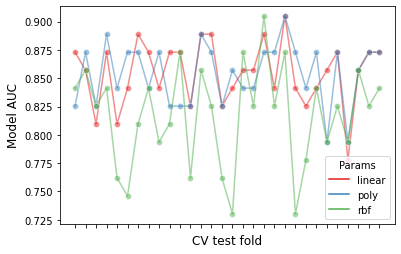

Correlation of models:
 Params    linear      poly       rbf
Params                              
linear  1.000000  0.705250  0.603156
poly    0.705250  1.000000  0.625825
rbf     0.603156  0.625825  1.000000


<Figure size 432x288 with 0 Axes>

In [129]:
# create df of model scores ordered by performance
model_scores = results_df.filter(regex=r"split\d*_test_score")

# plot 30 examples of dependency between cv fold and AUC scores
fig, ax = plt.subplots()
sns.lineplot(
    data=model_scores.transpose().iloc[:30],
    dashes=False,
    palette="Set1",
    marker="o",
    alpha=0.5,
    ax=ax,
)
ax.set_xlabel("CV test fold", size=12, labelpad=10)
ax.set_ylabel("Model AUC", size=12)
ax.tick_params(bottom=True, labelbottom=False)
plt.show()
plt.savefig('/content/drive/MyDrive/Graphs/correlation_svm_models.png')

# print correlation of AUC scores across folds
print(f"Correlation of models:\n {model_scores.transpose().corr()}")

In [130]:
import numpy as np
from scipy.stats import t


def corrected_std(differences, n_train, n_test):
    """Corrects standard deviation using Nadeau and Bengio's approach.

    Parameters
    ----------
    differences : ndarray of shape (n_samples,)
        Vector containing the differences in the score metrics of two models.
    n_train : int
        Number of samples in the training set.
    n_test : int
        Number of samples in the testing set.

    Returns
    -------
    corrected_std : float
        Variance-corrected standard deviation of the set of differences.
    """
    # kr = k times r, r times repeated k-fold crossvalidation,
    # kr equals the number of times the model was evaluated
    kr = len(differences)
    corrected_var = np.var(differences, ddof=1) * (1 / kr + n_test / n_train)
    corrected_std = np.sqrt(corrected_var)
    return corrected_std


def compute_corrected_ttest(differences, df, n_train, n_test):
    """Computes right-tailed paired t-test with corrected variance.

    Parameters
    ----------
    differences : array-like of shape (n_samples,)
        Vector containing the differences in the score metrics of two models.
    df : int
        Degrees of freedom.
    n_train : int
        Number of samples in the training set.
    n_test : int
        Number of samples in the testing set.

    Returns
    -------
    t_stat : float
        Variance-corrected t-statistic.
    p_val : float
        Variance-corrected p-value.
    """
    mean = np.mean(differences)
    std = corrected_std(differences, n_train, n_test)
    t_stat = mean / std
    p_val = t.sf(np.abs(t_stat), df)  # right-tailed t-test
    return t_stat, p_val

In [131]:
model_1_scores = model_scores.iloc[0].values  # scores of the best model
model_2_scores = model_scores.iloc[1].values  # scores of the second-best model

differences = model_1_scores - model_2_scores

n = differences.shape[0]  # number of test sets
df = n - 1
n_train = len(list(cross_val.split(X, y))[0][0])
n_test = len(list(cross_val.split(X, y))[0][1])

t_stat, p_val = compute_corrected_ttest(differences, df, n_train, n_test)
print(f"Corrected t-value: {t_stat:.3f}\nCorrected p-value: {p_val:.3f}")

Corrected t-value: 0.394
Corrected p-value: 0.347


In [132]:
t_stat_uncorrected = np.mean(differences) / np.sqrt(np.var(differences, ddof=1) / n)
p_val_uncorrected = t.sf(np.abs(t_stat_uncorrected), df)

print(
    f"Uncorrected t-value: {t_stat_uncorrected:.3f}\n"
    f"Uncorrected p-value: {p_val_uncorrected:.3f}")

Uncorrected t-value: 1.372
Uncorrected p-value: 0.087


In [133]:
# initialize random variable
t_post = t(
    df, loc=np.mean(differences), scale=corrected_std(differences, n_train, n_test)
)

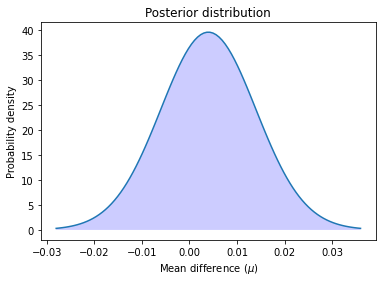

In [134]:
x = np.linspace(t_post.ppf(0.001), t_post.ppf(0.999), 100)

plt.plot(x, t_post.pdf(x))
plt.xticks(np.arange(-0.04, 0.06, 0.01))
plt.fill_between(x, t_post.pdf(x), 0, facecolor="blue", alpha=0.2)
plt.ylabel("Probability density")
plt.xlabel(r"Mean difference ($\mu$)")
plt.title("Posterior distribution")
plt.show()

In [135]:
better_prob = 1 - t_post.cdf(0)

print(
    f"Probability of {model_scores.index[0]} being more accurate than "
    f"{model_scores.index[1]}: {better_prob:.3f}"
)
print(
    f"Probability of {model_scores.index[1]} being more accurate than "
    f"{model_scores.index[0]}: {1 - better_prob:.3f}"
)

Probability of linear being more accurate than poly: 0.653
Probability of poly being more accurate than linear: 0.347


Probability of linear and poly being practically equivalent: 0.641


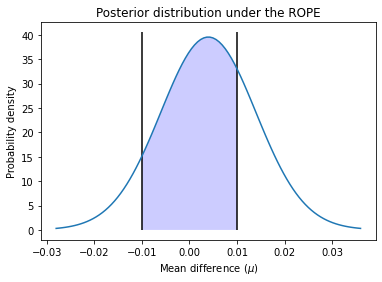

<Figure size 432x288 with 0 Axes>

In [136]:
rope_interval = [-0.01, 0.01]
rope_prob = t_post.cdf(rope_interval[1]) - t_post.cdf(rope_interval[0])

print(
    f"Probability of {model_scores.index[0]} and {model_scores.index[1]} "
    f"being practically equivalent: {rope_prob:.3f}"
)

x_rope = np.linspace(rope_interval[0], rope_interval[1], 100)

plt.plot(x, t_post.pdf(x))
plt.xticks(np.arange(-0.04, 0.06, 0.01))
plt.vlines([-0.01, 0.01], ymin=0, ymax=(np.max(t_post.pdf(x)) + 1))
plt.fill_between(x_rope, t_post.pdf(x_rope), 0, facecolor="blue", alpha=0.2)
plt.ylabel("Probability density")
plt.xlabel(r"Mean difference ($\mu$)")
plt.title("Posterior distribution under the ROPE")
plt.show()
plt.savefig('/content/drive/MyDrive/Graphs/posterior_kernel_distribution.png')

In [137]:
cred_intervals = []
intervals = [0.5, 0.75, 0.95]

for interval in intervals:
    cred_interval = list(t_post.interval(interval))
    cred_intervals.append([interval, cred_interval[0], cred_interval[1]])

cred_int_df = pd.DataFrame(
    cred_intervals, columns=["interval", "lower value", "upper value"]
).set_index("interval")
cred_int_df

,lower value,upper value
interval,,
0.50,-0.002846,0.010783
0.75,-0.007680,0.015616
0.95,-0.016005,0.023942


In [123]:
from itertools import combinations
from math import factorial

n_comparisons = factorial(len(model_scores)) / (
    factorial(2) * factorial(len(model_scores) - 2)
)
pairwise_t_test = []

for model_i, model_k in combinations(range(len(model_scores)), 2):
    model_i_scores = model_scores.iloc[model_i].values
    model_k_scores = model_scores.iloc[model_k].values
    differences = model_i_scores - model_k_scores
    t_stat, p_val = compute_corrected_ttest(differences, df, n_train, n_test)
    p_val *= n_comparisons  # implement Bonferroni correction
    # Bonferroni can output p-values higher than 1
    p_val = 1 if p_val > 1 else p_val
    pairwise_t_test.append(
        [model_scores.index[model_i], model_scores.index[model_k], t_stat, p_val]
    )

pairwise_comp_df = pd.DataFrame(
    pairwise_t_test, columns=["model_1", "model_2", "t_stat", "p_val"]
).round(3)
pairwise_comp_df

,model_1,model_2,t_stat,p_val
0,linear,poly,0.394,1.000
1,linear,rbf,2.927,0.006
2,poly,rbf,2.754,0.011


In [124]:
pairwise_bayesian = []

for model_i, model_k in combinations(range(len(model_scores)), 2):
    model_i_scores = model_scores.iloc[model_i].values
    model_k_scores = model_scores.iloc[model_k].values
    differences = model_i_scores - model_k_scores
    t_post = t(
        df, loc=np.mean(differences), scale=corrected_std(differences, n_train, n_test)
    )
    worse_prob = t_post.cdf(rope_interval[0])
    better_prob = 1 - t_post.cdf(rope_interval[1])
    rope_prob = t_post.cdf(rope_interval[1]) - t_post.cdf(rope_interval[0])

    pairwise_bayesian.append([worse_prob, better_prob, rope_prob])

pairwise_bayesian_df = pd.DataFrame(
    pairwise_bayesian, columns=["worse_prob", "better_prob", "rope_prob"]
).round(3)

pairwise_comp_df = pairwise_comp_df.join(pairwise_bayesian_df)
pairwise_comp_df

,model_1,model_2,t_stat,p_val,worse_prob,better_prob,rope_prob
0,linear,poly,0.394,1.000,0.084,0.275,0.641
1,linear,rbf,2.927,0.006,0.000,0.986,0.014
2,poly,rbf,2.754,0.011,0.000,0.977,0.022


In [138]:
pairwise_comp_df.to_csv('/content/drive/MyDrive/Graphs/pairwise_conf_probability.csv')

In [139]:
metrics.fbeta_score(y_val, y_predict, beta=0.5)

0.8726114649681528

<h1> Using selected features to further fine tune and select best parameters to tune the model. </h1>

<p1> For this, again will be using Isolation Forest to select outliers. Then feed the train and validation set through a pipeline to transform the data, normalize/scale it, and then further fine tune the hyperparameter settings through randomsearch and gridsearch cross validation.

In this I will also implement 10 RepeatedKFolds. </p1>

In [184]:
"""

Selecting ideal features using both heatmap correalation and feature importance on impurity

"""

features = ['F10', 'F17', 'F20', 'F21', 'F11', 'F18', 'F2', 'F13', 'F15', 'F12', 'F8']

X = df_copy[features[:-1]]
y = pd.DataFrame(df_copy['Class'])
y = np.ravel(y)

In [185]:
X

,F10,F17,F20,F21,F11,F18,F2,F13,F15,F12
0,0.624838,0.414685,0.936954,0.524858,0.659431,0.404247,0.021560,0.002096,0.931620,0.0
1,0.393301,0.454283,0.987632,0.646952,0.707251,0.339125,0.040826,0.008924,0.931315,0.0
2,0.597069,0.402988,0.842678,0.485975,0.676642,0.325149,0.068288,0.006651,0.932849,0.0
3,0.513655,0.445595,0.939842,0.378702,0.622376,0.389669,0.252751,0.039946,0.933420,0.0
4,0.606091,0.356179,0.941269,0.430894,0.669805,0.353157,0.042808,0.042844,0.934021,0.0
...,...,...,...,...,...,...,...,...,...,...
995,0.558131,0.383952,0.995497,0.474866,0.639676,0.342145,0.167825,0.170801,0.934594,1.0
996,0.535496,0.426366,0.990033,0.474838,0.688110,0.353650,0.533164,0.142186,0.930586,0.0
997,0.525377,0.445772,0.999972,0.648172,0.633682,0.327479,0.903782,0.150868,0.933807,1.0
998,0.528125,0.426011,0.908388,0.323155,0.662369,0.364922,0.167090,0.174836,0.932907,1.0


In [186]:
y

array([0., 0., 0., 1., 0., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0.,
       1., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 1., 0., 0., 1., 1.,
       0., 1., 0., 0., 0., 0., 1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0.,
       0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 1., 0., 1., 0., 0., 0.,
       0., 0., 1., 1., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0., 1., 1., 0.,
       0., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 0., 1., 1., 1.,
       0., 0., 1., 1., 0., 1., 0., 0., 0., 1., 0., 0., 0., 1., 0., 1., 0.,
       1., 1., 0., 1., 1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 0., 0., 1., 0., 1., 1., 1., 1., 1., 0., 0., 0., 1.,
       1., 1., 0., 0., 1., 1., 1., 1., 0., 1., 0., 1., 1., 1., 0., 1., 1.,
       0., 0., 0., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 1., 0., 1.,
       0., 0., 1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 1., 1., 0., 0., 0.,
       1., 0., 0., 1., 0., 1., 1., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0.,
       0., 0., 1., 0., 1.

In [187]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, shuffle=True)

In [188]:
X_train.shape

(750, 10)

In [189]:
X_test.shape

(250, 10)

In [190]:
y_train.shape

(750,)

In [191]:
y_test.shape

(250,)

In [192]:
"""

Creating a new pipeline to iterate over the three classifiers as outlined in the report

This will mean using a cross validation method to define the best parameters for the models.
Once completed, hyperparameter tuning can begin to further refine the model. The model can be saved and then
implemented going forward.

  - Decision Tree Classifier (Implementing to give a baseline)
  - RandomForestClassifier
  - SupportVectorClassifier

  # using a quantile transformer which already contains a normalization/standardization step
  # Setting it to Gaussian Normal Distribution as seen from EDA, data is highly skewed.

"""

from sklearn.svm import SVC
from sklearn.model_selection import cross_validate

# creating an empty list to store the classifiers

from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score

from sklearn.metrics import accuracy_score

from sklearn.preprocessing import QuantileTransformer


qt = QuantileTransformer(n_quantiles=100, output_distribution='normal')


pipeline = Pipeline([
    ('Transformer', qt),
    
    ('clf', RandomForestClassifier()) #step2 - classifier
])


pipeline.steps

clfs = []
clfs.append(SVC())
clfs.append(DecisionTreeClassifier())
clfs.append(RandomForestClassifier())


for classifier in clfs:
    pipeline.set_params(clf = classifier)
    scores = cross_validate(pipeline, X_train, y_train)
    print('---------------------------------')
    print(str(classifier))
    print('-----------------------------------')
    for key, values in scores.items():
            print(key,' mean ', values.mean())
            print(key,' std ', values.std())


---------------------------------
SVC()
-----------------------------------
fit_time  mean  0.029074764251708983
fit_time  std  0.0027418779970996335
score_time  mean  0.014394330978393554
score_time  std  0.0023276765774097726
test_score  mean  0.8640000000000001
test_score  std  0.034922135609890124
---------------------------------
DecisionTreeClassifier()
-----------------------------------
fit_time  mean  0.01822052001953125
fit_time  std  0.0013323620576153386
score_time  mean  0.007965993881225587
score_time  std  0.0005052154251665452
test_score  mean  0.8293333333333333
test_score  std  0.03991101212558871
---------------------------------
RandomForestClassifier()
-----------------------------------
fit_time  mean  0.2464989185333252
fit_time  std  0.010167492558163377
score_time  mean  0.0206573486328125
score_time  std  0.0016071448734746
test_score  mean  0.8653333333333334
test_score  std  0.029028721409436326


In [194]:
"""
Time to refit our Random Forest Classifier and the SVC on the renewed features as they showed the most promise

"""

"""
Random Search through all variables to find best fit

Defining parameters within a wide range allows best chance of finding further optimisation patterns.

"""
# Setting the parameters of our random search for the classifier 

X_train = qt.fit_transform(X_train)

forest_params = {'min_samples_split': [2,5,8,10,12],
          'min_samples_leaf': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100],
          'max_features': ['log2'], 
          'max_depth': [50, 55, 60, 65, 70],
          'n_jobs': [-1],
          'random_state': [42],
          'n_estimators': range(10, 2000),
          'criterion': ['entropy','gini']}

steps = [('Transformer', qt),
          ('Classifier', forest)]


pipeline = Pipeline(steps)


# creating our random search instance
forest_search = RandomizedSearchCV(forest,param_distributions=forest_params, cv=10, n_jobs=-1, verbose=True, scoring='f1')

# fitting random search to the data
forest_search.fit(X_train, y_train)

# getting the best estimations for parameters and score
print("Best parameters from randomsearch: {}".format(forest_search.best_params_))
print("CV score=%0.3f" % forest_search.best_score_)


Fitting 10 folds for each of 10 candidates, totalling 100 fits
Best parameters from randomsearch: {'random_state': 42, 'n_jobs': -1, 'n_estimators': 506, 'min_samples_split': 2, 'min_samples_leaf': 90, 'max_features': 'log2', 'max_depth': 55, 'criterion': 'entropy'}
CV score=0.862
